09/25/2016  
by Numan Laanait  
email: laanaitn@ornl.gov


#Description
Before we can analyze a particular dataset a number of processing steps must be applied to the images.  
Depending on the type of data, these processing steps must vary.  
This notebook details corrections for acquisition time and illumination correction.  
Below we'll apply it to 2 types of datasets:

    a. Non spatially resolved data: this is just a standard XRD scan (L-scans).
    b. Spatially resolved data: this is XDM. (loopscan and lscans).

In the following notebook, we'll do one of each.


### Prerequisites:
Due to the large number of images, we'll need to use all the CPUs we have available. 
We'll use 2 libraries: 

        a. PyXRIM: this is a custom library that is included in the dropbox folder.
        b. multiprocess: this is a library that you must install. 
Regarding the installation of `multiprocess` if you use Linux or Mac, then `pip install multiprocess` is all you need.

For windows, you need a little bit more. See the instructions in the folder. 

In [14]:
# Imports
import numpy as np
import os
from matplotlib import pyplot as plt
import h5py as h5
from PyXRIM.Corrections import Corrector
from PyXRIM.misc import  bin_ndarray
%matplotlib notebook

In [3]:
# open h5file
fname = '/home/nl7/work/xray_data/LiCoO2_Al2O3_20160330.hdf5'
f = h5.File(fname, mode='r') 
# Always open in read mode 'r'.
# Until you're ready to write into the file. This is especially true if your OS is not Unix-based like Windows.
rawg = f['20160330/Raw']
procg = f['20160330/Process']
meta = f['20160330/Meta']

###We need 'READ' and 'DARK' images. These are files that contain the readout and dark currents, respectively of the detector (CMOS) that was used.

## 1. XRD Scans

In [13]:
metag = f['20160330/Meta']
READ = metag['READ']
DARK = metag['DARK']
print READ.shape
# f.close()

(2048, 2048)


Let's read an L-scan, and plot the total image intensity.  
This is an L-scan through the Bragg peak of the LiCoO3 film.

<IPython.core.display.Javascript object>


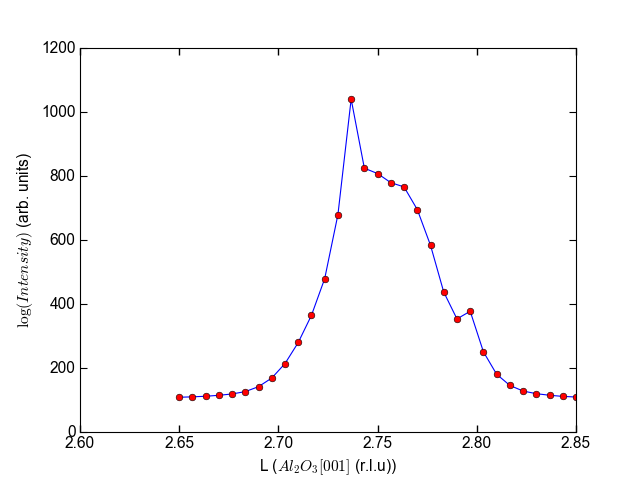

In [26]:
dset = rawg['S039']
L = dset.attrs['L']
Int = dset[:].mean(axis=(1,-1))
fig,ax = plt.subplots()
ax.plot(L,Int[:],marker = 'o', markerfacecolor='r')
ax.set_xlabel('L ($Al_2O_3 [001]$ (r.l.u))')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

Note that the images in this scan have (x,y) dimensions of (1024,1024). So we need to bin the correction files before we can use them.

In [33]:
# Let's bin the correction files
read2x = bin_ndarray(READ[:], (1024,1024))
dark2x = bin_ndarray(DARK[:], (1024,1024))
# Correcting for the ccd noise
cr = Corrector()
cr.loadData(dset)
bkgData = cr.bkgSubtract(read2x,dark2x)

We also need to normalize with respect to exposure time, ion chamber and filters.

In [34]:
# normalization
normData = cr.normalize(monitor=None, trans = 'trans', use_processed=True)

Let's plot the normalized data

<IPython.core.display.Javascript object>


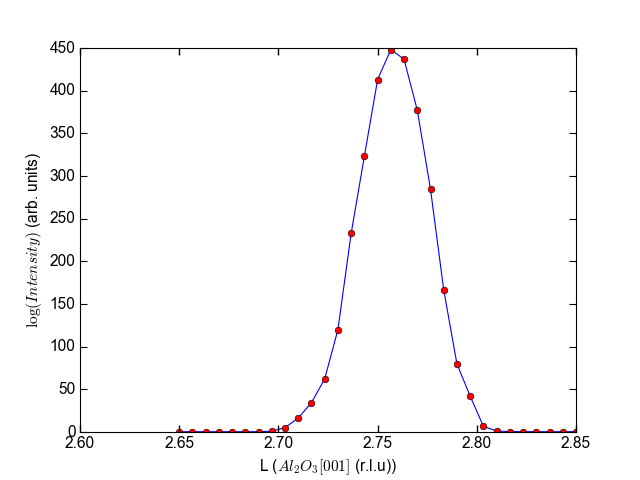

In [35]:
normInt = normData.mean(axis=(1,-1))
fig,ax = plt.subplots()
ax.plot(L,normInt[:],marker = 'o', markerfacecolor='r')
ax.set_xlabel('L ($Al_2O_3 [001]$ (r.l.u))')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

Let's look at one of the images, so we can define an integration window.

<IPython.core.display.Javascript object>


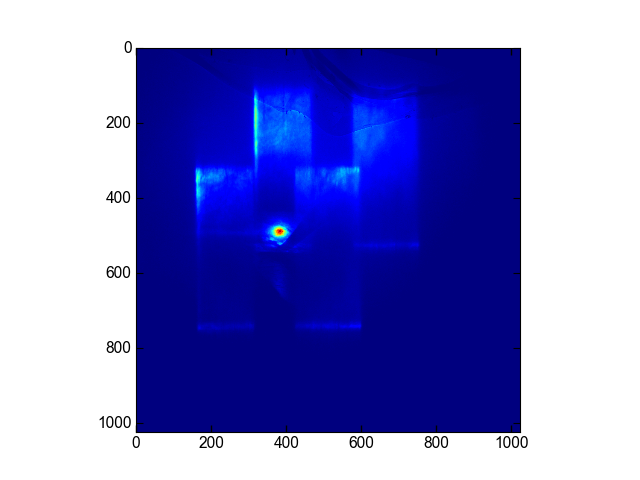

In [37]:
fig,ax= plt.subplots()
ax.imshow(normData[normData.shape[0]/2])

<IPython.core.display.Javascript object>


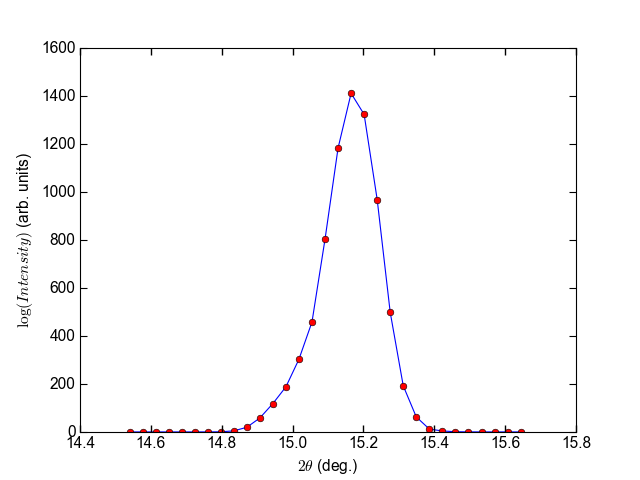

In [46]:
# from above image we need to extract the coordinates of the square, that's the reflected beam.
roiy = slice(325,735,None)
roix = slice(165,605,None)
normInt = normData[:,roiy,roix].mean(axis=(1,-1))
fig,ax = plt.subplots()
twotheta = dset.attrs['delta']
ax.plot(twotheta,normInt[:],marker = 'o', markerfacecolor='r')
ax.set_xlabel('$2\\theta$ (deg.)')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

#### From the above data we can calculate the d-spacing (003) for the thin-film, etc ...
We'll talk later about how to save normData into the hdf5 file so we don't have to do this everytime!!
## 2. XDM scan
Now we'll do the same as before, except we'll correct an XDM L-scan.

<IPython.core.display.Javascript object>


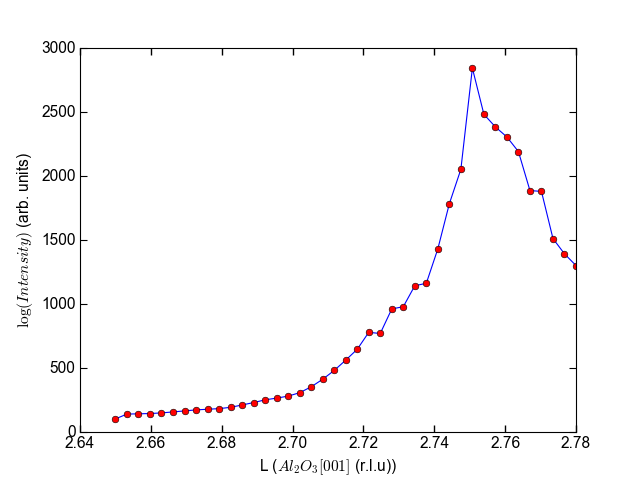

In [115]:
dset = rawg['S026']
L = dset.attrs['L']
Int = dset[:].mean(axis=(1,-1))
fig,ax = plt.subplots()
ax.plot(L,Int[:],marker = 'o', markerfacecolor='r')
ax.set_xlabel('L ($Al_2O_3 [001]$ (r.l.u))')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

In [117]:
# Correcting for the ccd noise
cr = Corrector()
cr.loadData(dset)
bkgData = cr.bkgSubtract(read2x,dark2x)
# normalization
normData = cr.normalize(monitor=None, trans = 'trans', use_processed=True)

Let's spatially average the data to get a sense of what's in there...

<IPython.core.display.Javascript object>


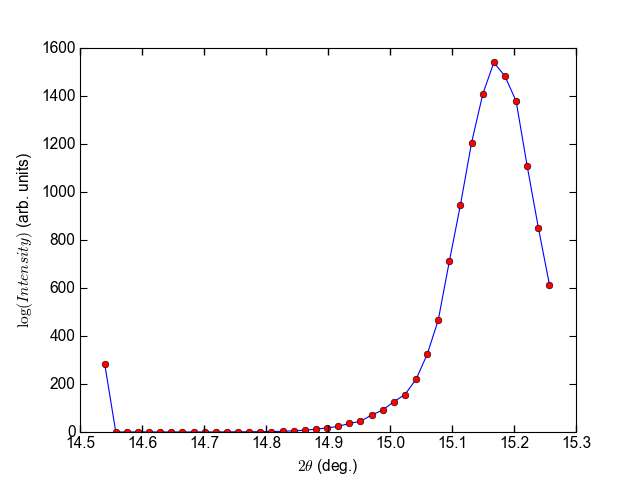

In [118]:
# Averaging of spatial coordinates
normInt = normData[:].mean(axis=(1,-1))
fig,ax = plt.subplots()
twotheta = dset.attrs['delta']
ax.plot(twotheta,normInt[:],marker = 'o', markerfacecolor='r')
ax.set_xlabel('$2\\theta$ (deg.)')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

Let's look at a single image and choose 2 regions and look at their diffraction signals

<IPython.core.display.Javascript object>


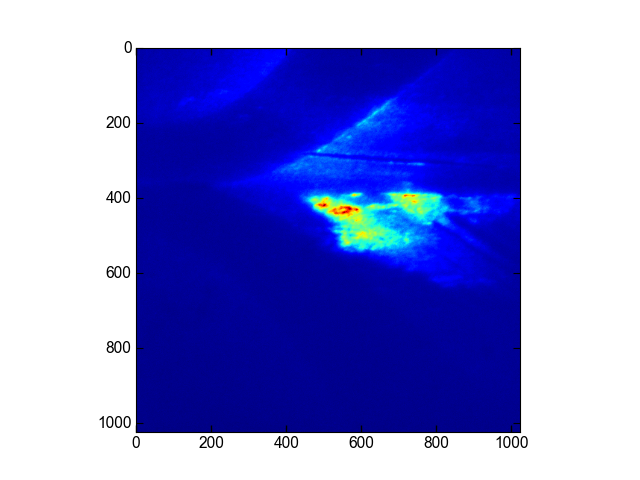

In [147]:
fig,ax= plt.subplots()
ax.imshow(normData[26], cmap = 'jet')
#Let's focus on that bright domains
roi1y=slice(420,460)
roi1x=slice(500,580)
# Let's take this one from a different region
roi2y=slice(320,400)
roi2x=slice(420,500)

<IPython.core.display.Javascript object>


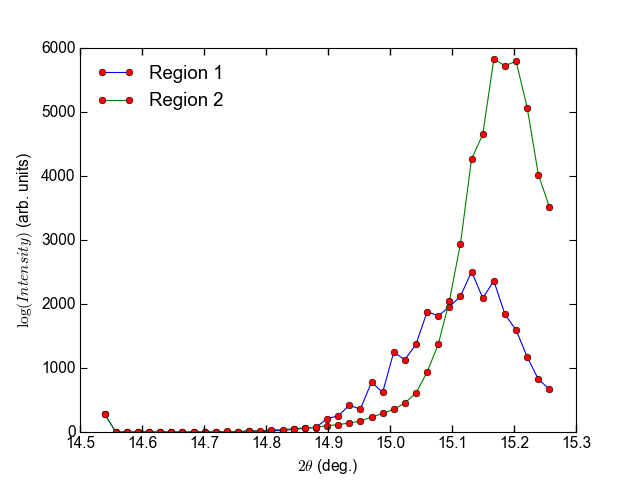

In [152]:
Int1 = normData[:,roi1y,roi1x].mean(axis=(1,-1))
Int2 = normData[:,roi2y,roi2x].mean(axis=(1,-1))
fig,ax = plt.subplots()
twotheta = dset.attrs['delta']
ax.plot(twotheta,Int1,marker = 'o', markerfacecolor='r',label='Region 1')
ax.plot(twotheta,Int2,marker = 'o', markerfacecolor='r',label='Region 2')
ax.legend(loc='upper left')
ax.set_xlabel('$2\\theta$ (deg.)')
ax.set_ylabel('$\log (Intensity) $ (arb. units)')

From the peaks of the 2 curves we see that regions 1 and 2 have different d-spacing (~ 1%, this is huge for a crystal). This change in d-spacing is induced by diffusion of Li. Note also that there's significant broadening indicating the presence of other lattice distortions.

###Outlook
We can extract the same information (in a more rigourous way) by using decomposition techniques (such NMF, PCA). But that's the subject of another notebook.  
Also to analyze the movies (loopscan, e.g. 'S022') would require that we do some more image processing (flat-field correction, patter recognition). These are also the subject of another notebook.

##Saving Data
Once you process a dataset, save it under `'20160330/Process'` group.  
Here are a few lines of code that do this.  
Note that we also link it to the original dataset in `Raw` so that we may access its attributes.

In [ ]:
# Setup some basic parameters
fpath = '/home/nl7/work/xray_data/LiCoO2_Al2O3_20160330.hdf5' # Path to h5file
rawDsetName = 'SXXX' # name of raw dataset
procName = 'SXXX_corrected' # name of processed data
procData = normData # numpy array of processed data
procRefName = 'bkg_corrected' # reference name to append to rawData
f.close() # we need to close the h5file so we can open with read/write permissions

In [ ]:
# Write data into h5-file
with h5.File(fpath, 'r+') as f:
    rawg = f['20160330/Raw']
    rawDset = rawg[rawDsetName]
    procg = f['20160330/Process']
    newDsetName = procName
    newDset = procg.create_dataset(newDsetName, data = procData , dtype =np.float64,
                                    compression = 'lzf')
    rawDset.attrs[procRefName]=newDset.ref

To access the corrected dataset associated with `procData`, we'll use the reference `procRefName` that we appended to `rawData`.

In [ ]:
# To access the corrected dataset, we'll use the reference that we appended to rawData
fname = '/home/nl7/work/xray_data/LiCoO2_Al2O3_20160330.hdf5'
f = h5.File(fname, mode='r') 
rawg = f['20160330/Raw']
rawDset = rawg[rawDataName]
procDset = f[rawDset.attrs(procRefName)]
